## Bibliotecas Usadas

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Classe para Executar Script

In [2]:
class executarProtocolo:
    def __init__(self, arquivo, protocolo, caminho = 'scratch/'):
        self.arquivo = arquivo
        self.caminho = caminho
        self.protocolo = protocolo
        
    def __call__(self, velocidade, iteracao, script = './waf', comando_script = '--run'):
        
        comando = script + " " + comando_script + " " + """ "{}{} {} {} {}" """.format(self.caminho, 
                                                                                          self.arquivo, 
                                                                                          self.protocolo, 
                                                                                          velocidade, 
                                                                                      iteracao)        
        return os.system(comando)
    
    
    def fit(self, velocidades, unidade='Mbps', npmax=30):
        
        for velocidade in velocidades:
            flag = str(velocidade)+unidade
            
            for i in range(npmax):
                self(flag, str(i))
            
            print("Simulacao da velocidade {} pronta".format(velocidade))
        return 0

## Gerando arquivos para as simulações

In [3]:
udp = executarProtocolo('Simulacao','Udp')
tcp = executarProtocolo('Simulacao','Tcp')

In [4]:
#udp.fit(np.arange(5,16,5))
#tcp.fit(np.arange(5,16,5)) 

## Analisando os Arquivos nos Diretórios

# Leitor de Arquivo

In [5]:
def lerArquivo(caminho):
    tag = []
    tempo = []
    identificacao =[]

    with open(caminho, 'r') as file:

        for line in file:
            info = line.split(' ')

            tag.append(info[0])

            tempo.append(info[1])

            identificacao.append(info[18])

    return pd.DataFrame(data = {'tag': tag, 'tempo': tempo, 'id': identificacao})
    

# Percorrer os Arquivos Gerados

In [6]:
def lerPasta(pasta):
    df = []
    for _, _, arquivos in os.walk(pasta):
        
        for arquivo in arquivos:
            atributos = arquivo.split("-")

            dp = lerArquivo(pasta + "/" + arquivo)

            dp['protocolo'] = atributos[0]

            dp['velocidade'] = atributos[2]

            dp['iteracao'] = atributos[3].replace('.tr','')

            df.append(dp)
    return pd.concat(df, ignore_index = True)

## Lendo os Diretórios e montando os DataFrames

In [7]:
dudp = lerPasta('Udp')
dtcp = lerPasta('Tcp')

# Mudando o tipo das colunas

In [8]:
dudp['id'] = pd.to_numeric(dudp['id'])
dudp['iteracao'] = pd.to_numeric(dudp['iteracao'])
dudp['tempo'] = pd.to_numeric(dudp['tempo'])

dtcp['id'] = pd.to_numeric(dtcp['id'])
dtcp['iteracao'] = pd.to_numeric(dtcp['iteracao'])
dtcp['tempo'] = pd.to_numeric(dtcp['tempo'])

# Função de calculo de tempo e intervalo de confiança

In [9]:
def calculoDeTempo(df):
    ordem = np.sort(np.array(df['tempo']))
    
    return abs(ordem[0] - ordem[-1])

In [10]:
def calculoDeConfianca(lista_de_tempo):
    media = np.mean(lista_de_tempo)

    soma = 0

    for i in lista_de_tempo:
        soma += (media - i)**2

    desvio_padrao = np.sqrt(soma/len(lista_de_tempo)) 

    return 1.95 * desvio_padrao/ np.sqrt(len(lista_de_tempo))


# Analisando os DataFrames

In [11]:
def analisadorDeDataFrame(df):
    
    velocidadesf = []
    tempo_medio = []
    pacotes_enviados = []
    intervaloC = []
    
    for velocidade in df['velocidade'].unique():
        
        temposp = []
        pacotesp = []
        
        for iteracao in df['iteracao'].unique():
            
            dp = df[(df['velocidade'] == velocidade) & (df['iteracao'] == iteracao)].filter(items= ['tempo', 'id'])
            
            temposp.append(calculoDeTempo(dp))
            
            pacotesp.append(len(df['id'].unique()))
                        
        velocidadesf.append(velocidade) 
        tempo_medio.append(np.mean(temposp)) 
        pacotes_enviados.append(np.mean(pacotesp))
        intervaloC.append(calculoDeConfianca(temposp))
        
    return pd.DataFrame(data = {'velocidade': velocidadesf,
                               'tempo medio': tempo_medio,
                               'pacotes enviados': pacotes_enviados,
                               'intervaloC': intervaloC})

# Montando o resultado UDP

In [12]:
resultado_udp = analisadorDeDataFrame(dudp)

In [13]:
resultado_udp

,velocidade,tempo medio,pacotes enviados,intervaloC
0,15Mbps,9.11844,25999.0,0.000000e+00
1,5Mbps,9.14774,25999.0,0.000000e+00
2,10Mbps,9.12574,25999.0,6.324180e-16


# Montando o resultado TCP

In [14]:
resultado_tcp = analisadorDeDataFrame(dtcp)

In [15]:
resultado_tcp

,velocidade,tempo medio,pacotes enviados,intervaloC
0,10Mbps,9.2108,15969.0,6.324180e-16
1,5Mbps,9.3202,15969.0,0.000000e+00
2,15Mbps,9.1752,15969.0,0.000000e+00


# Plotando Resultados

# Velocidade pelo Tempo

In [16]:
def plotarVxT(sim1, sim2):
    a = sim1.sort_values('tempo medio')
    b = sim2.sort_values('tempo medio')
    
    plt.plot(a['velocidade'], a['tempo medio'],'--o', label = 'Udp')
    plt.plot(b['velocidade'], b['tempo medio'],'--^', label = 'Tcp')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    
    plt.title('Velocidade pelo Tempo')
    plt.xlabel('velocidade')
    plt.ylabel('tempo medio')

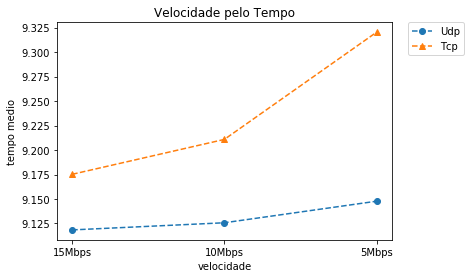

In [17]:
plotarVxT(resultado_udp, resultado_tcp)

# Pacotes enviados pela velocidade

In [18]:
def eficiencia(sim1, sim2):
    a = sim1.sort_values('tempo medio')
    b = sim2.sort_values('tempo medio')

    plt.bar(a['velocidade'], a['pacotes enviados'], label = 'Udp')
    plt.bar(b['velocidade'], b['pacotes enviados'], label = 'Tcp')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


    plt.title('Eficiencia por velocidade')
    plt.xlabel('velocidade')
    plt.ylabel('pacotes')

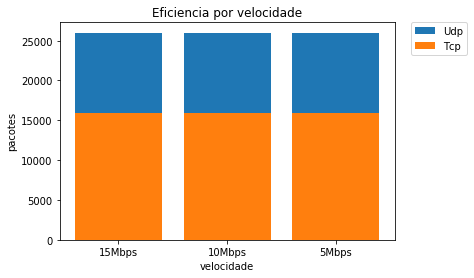

In [19]:
eficiencia(resultado_udp, resultado_tcp)